# Validation of Nigeria model

This notebooks investigates the results obtained by pypsa-africa model for the Nigeria case.
In particular, public information of the power system of Nigeria are compared to those used and obtained from the pypsa-africa model.

The following quantities will be reviewed:
- inputs used by the pypsa-model:
  - network characteristics
  - substations
  - installed generation by type
- outputs of the simulation
  - demand
  - energy production shares

To properly reproduce the findings obtained in this notebook, please run the full snakemake procedure on the Nigeria case only.
To do so, please set ``countries = ["NG"]`` in the ``config.yaml`` file.

## Preparation

### Set main directory to root folder

In [1]:
# set current folders

import sys

sys.path.append("../../")  # to import helpers

from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")

This is the repository path:  c:\Users\Max\Desktop\pypsa-africa
Had to go 2 folder(s) up.


### Definition of main folder paths

In [2]:
import os

# OSM raw data files
substations_OSMraw_path = (
    os.getcwd() + "/resources/osm/raw/africa_all_raw_substations.geojson"
)
lines_OSMraw_path = os.getcwd() + "/resources/osm/raw/africa_all_raw_lines.geojson"

# cleaned osm data files
substations_OSMclean_path = (
    os.getcwd() + "/resources/osm/clean/africa_all_substations.geojson"
)
lines_OSMclean_path = os.getcwd() + "/resources/osm/clean/africa_all_lines.geojson"

# shapes files
countries_shape_path = os.getcwd() + "/resources/shapes/country_shapes.geojson"

# solve network output
solved_network_path = os.getcwd() + "/results/networks/elec_s_54_ec_lcopt_Co2L-1H.nc"

### Import packages

In [3]:
# import packages

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

## 1. Analysis of network of the Nigeria case

In this subsection, the data publicy on the network power system are compared. In particular, the main data that are being compared are:
- Layout of the network as shown by images (Section 1.1)
- Total length of the line (Section 1.2)

The data used for the comparison have been taken from public reliable sources, with strong focus on the website of the Nigerian Transmission operator: Nigerian Transmission Company ([TCN](https://www.tcn.org.ng/)).

In the Section 1.1, the network layout obtained by the workflow is drawn to be possibly compared with the image as shown in the public website of the [Nigerian Transmission System Operator](https://www.tcn.org.ng/). The image below, dated 2016, available from the [Nigerian Transmission System Operator](https://www.tcn.org.ng/), depicts the national power grid of Nigeria.

![Nigerian transmission system](../../images/Nigeria_data/Nigeria_network_map.png)
[Source link](https://www.tcn.org.ng/repository/maps/GRID%20MAP%20FOR%20EXISTING%20TRANSMISSION%20AND%20GENERATION%20NETWORK.pdf)

In the Section 1.2, the network length as obtained from the workflow is calculated to then be compared with the information reported by the Nigerian TSO. According to the data available from the [Transmission Company of Nigeria (ISO)](https://nerc.gov.ng/index.php/home/nesi/404-transmission), in Nigeria, there are:

- \> 20000km lines
- \> 7500MW line capacity

These information shall be close to those obtained by the workflow.

### 1.1. Network layout (using OSM clean data)

In this section, the cleaned OSM data are used to draw plots of the entire network, to reproduce the image available from the Nigerian TSO and verify the quality of the pypsa-africa model.

#### 1.1.1. Load clean OSM data

In [4]:
# load substation geodataframe
df_substations_osm_clean = gpd.read_file(
    substations_OSMclean_path
)  # .to_crs(epsg=3857)
# df_substations_osm_clean = df_substations_osm_clean[
#     df_substations_osm_clean.country == "NG"
# ]
df_substations_osm_clean["geometry"] = df_substations_osm_clean["geometry"].apply(
    make_valid
)
# load lines geodataframe
df_lines_osm_clean = gpd.read_file(lines_OSMclean_path)  # .to_crs(epsg=3857)
# df_lines_osm_clean = df_lines_osm_clean[df_lines_osm_clean.country == "NG"]
df_lines_osm_clean["geometry"] = df_lines_osm_clean["geometry"].apply(make_valid)

#### 1.1.2. Calculate voltage levels for substations and lines

Substations voltage level [V]

In [5]:
voltage_substations = df_substations_osm_clean.voltage.unique()
voltage_substations.sort()
voltage_substations

array([132000, 330000], dtype=int64)

Lines voltage level [V]

In [6]:
unique_voltages = df_lines_osm_clean.voltage.unique()
unique_voltages.sort()
unique_voltages

array([132000, 330000], dtype=int64)

#### 1.1.3. Specify colors for voltage levels in agreement with the image by the TSO

Specify color array by voltage level

In [7]:
color_voltages = ["orange", "blue", "red"]

voltage_to_color = {v: c for (v, c) in zip(unique_voltages, color_voltages)}
voltage_to_color

{132000: 'orange', 330000: 'blue'}

#### 1.1.4. Plot the network data

Get the borders of the country shape to perform the desired plot

In [8]:
# get all country shapes
country_shapes = gpd.read_file(countries_shape_path)

# get nigeria shape
nigeria_shape = country_shapes.set_index("name").geometry

# get bounds
# print("Original bounds:")
# print(nigeria_shape.boundary.bounds)

# add tolerance to bounds
tol = 0.2

bounds_mod = nigeria_shape.boundary.bounds
bounds_mod["minx"] -= tol  # reduce minx
bounds_mod["miny"] -= tol  # reduce miny
bounds_mod["maxx"] += tol  # increase maxx
bounds_mod["maxy"] += tol  # increase maxy

print("Modified bounds:")
print(bounds_mod)

# reorder bounds to comply with extend function (x0, x1, y0, y1)
extent_list = (
    float(bounds_mod["minx"]),
    float(bounds_mod["maxx"]),
    float(bounds_mod["miny"]),
    float(bounds_mod["maxy"]),
)

Modified bounds:
          minx      miny       maxx      maxy
name                                         
NG    2.468431  4.070418  14.876219  14.09201


Draw the picture using pyplot

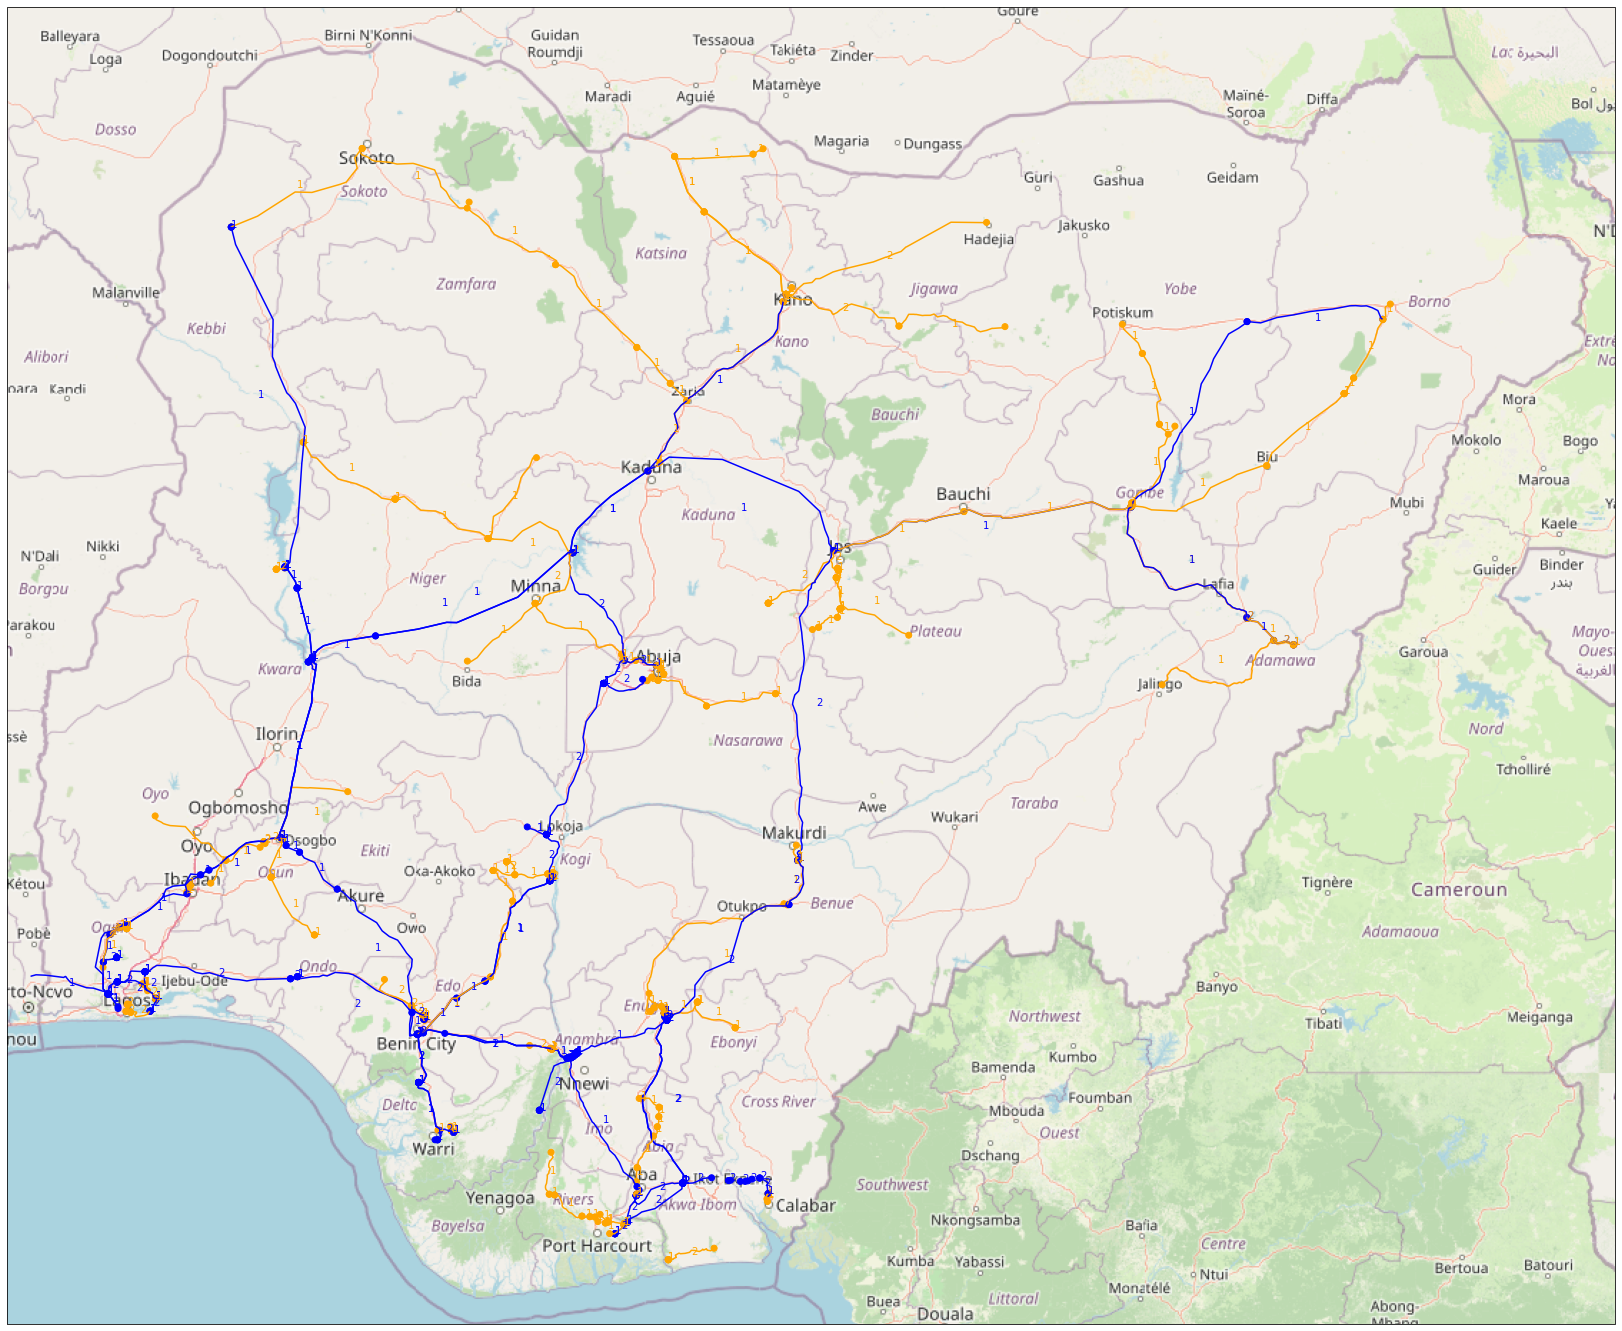

In [9]:
%matplotlib inline

# get the structure of the background data to plot
imagery = OSM()

max_width = 30  # max width of the figure
max_height = 30  # max heifht of the figure

# calculate figure size with appropriate multiplier to adhere to the desired width/height
multiplier = min(
    max_width / (extent_list[1] - extent_list[0]),
    max_height / (extent_list[3] - extent_list[2]),
)
figsize = (
    (extent_list[1] - extent_list[0]) * multiplier,
    (extent_list[3] - extent_list[2]) * multiplier,
)


fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)  # specify projection
ax.set_extent(extent_list, ccrs.PlateCarree())  # specify the location of the image
ax.add_image(imagery, 7)  # add the background image

# create an auxiliary dataframe for the substations with the desired crs and color properties
df_substations_osm_clean_plot = df_substations_osm_clean.to_crs(imagery.crs)
# specify the color of the nodes
df_substations_osm_clean_plot["color"] = df_substations_osm_clean_plot.voltage.apply(
    lambda x: voltage_to_color[x]
)


# create an auxiliary dataframe for the lines with the desired crs and properties
df_lines_osm_clean_plot = df_lines_osm_clean.to_crs(imagery.crs)
df_lines_osm_clean_plot[
    "centroids"
] = df_lines_osm_clean_plot.geometry.boundary.centroid  # get the centroids of the line
df_lines_osm_clean_plot["color"] = df_lines_osm_clean_plot.voltage.apply(
    lambda x: voltage_to_color[x]
)  # specify the color of the line

# draw the substations
df_substations_osm_clean_plot.plot(color=df_substations_osm_clean_plot.color, ax=ax)

# draw the lines
df_lines_osm_clean_plot.plot(color=df_lines_osm_clean_plot.color, ax=ax)

# add annotations to show the number of circuits by line
for (id, row) in df_lines_osm_clean_plot.iterrows():
    ax.text(row.centroids.x, row.centroids.y, row.circuits, color=row.color)

Add the equivalent map but with interactive features

In [10]:
# Disabled to ease the data storing in github; decomment to use

# df_substations_osm_clean[df_substations_osm_clean.voltage == unique_voltages[0]].hvplot(
#     geo=True,
#     size = 10,  # buses["tag_area"]**(0.5)/10,
#     frame_height=750,
#     alpha=0.4,
#     tiles='CartoLight',
#     color=color_voltages[0],
#     hover_cols=['bus_id'],
# ) * df_substations_osm_clean[df_substations_osm_clean.voltage == unique_voltages[1]].hvplot(
#     geo=True,
#     alpha=0.4,
#     color=color_voltages[1],
#     hover_cols=['bus_id'],
# ) * df_substations_osm_clean[df_substations_osm_clean.voltage == unique_voltages[2]].hvplot(
#     geo=True,
#     alpha=0.4,
#     color=color_voltages[2],
#     hover_cols=['bus_id'],
# ) * df_lines_osm_clean[df_lines_osm_clean.voltage == unique_voltages[0]].hvplot(
#     geo=True,
#     color=color_voltages[0],
#     alpha=0.4,
#     hover_cols=['circuits', 'line_id'],
# ) * df_lines_osm_clean[df_lines_osm_clean.voltage == unique_voltages[1]].hvplot(
#     geo=True,
#     color=color_voltages[1],
#     alpha=0.4,
#     hover_cols=['circuits', 'line_id'],
# ) * df_lines_osm_clean[df_lines_osm_clean.voltage == unique_voltages[2]].hvplot(
#     geo=True,
#     color=color_voltages[2],
#     alpha=0.4,
#     hover_cols=['circuits', 'line_id'],
# ).opts(
#     active_tools=['pan', 'wheel_zoom']
# )

#### 1.1.5. Comments on the network layout

By comparing the image of the existing lines availabe from TCN and the plots obtained from the workflow, it is possible to notice that they overlap and there are only minimal differences.

However, the available source is dated 2016 and, as stated by the same [TCN source](https://www.tcn.org.ng/repository/maps/GRID%20MAP%20FOR%20EXISTING%20TRANSMISSION%20AND%20GENERATION%20NETWORK.pdf), there where several transmission lines projects ongoing in 2015.
Therefore, the current model available in OSM may be sligthly outdated, but it draws a good picture of the current situation, given the available sources.

### 1.2. Calculate the total length of the lines

In this section, the total length of the lines are obtained. To do so, the following actions are performed:
1. Preliminary data loading
2. Crosscheck the unit of measurement to verify that the units are in meters [m]
3. Crosscheck the number of circuits for geometry line in the raw OSM dataset
4. Evaluate the total length of the lines in the raw OSM dataset
5. Evaluate the total length of the lines in the clean OSM dataset
6. Remarks on the line length

Note: the OSM dataset reports the geometry paths of the lines; however, in the same geometry path there may multiple circuits. That information is contained in the number of cables for geometry line, which is the reason why this information is properly addressed in point 3 (Subsection 1.2.3).

#### 1.2.1 Preliminary data loading of raw OSM data

In the following, we show the input data downloaded from OSM; the clean data have already been loaded.

In [11]:
# load substation geodataframe
df_substations_osm_raw = gpd.read_file(substations_OSMraw_path)
# df_substations_osm_raw = df_substations_osm_raw[df_substations_osm_raw.Country == "NG"]
# load lines geodataframe
df_lines_osm_raw = gpd.read_file(lines_OSMraw_path)
# df_lines_osm_raw = df_lines_osm_raw[df_lines_osm_raw.Country == "NG"]

# note that epsg=3857 has been chosen so that lenghts are in meters

#### 1.2.2 Crosscheck the unit of measurement

In the following, we verify that the property ``geometry.length`` can be successfully used to measure the length of the line in meters (spoiler, it is). To do so, we need to use the crs ``EPSF:3763`` and compare the obtained value with the column ``Length`` available in the raw OSM data of dataframe ``df_lines_osm_raw``.

As shown below, the two informations are very close which confirm the proposed approach.

In [12]:
df_lines_osm_raw["length_by_geometry"] = df_lines_osm_raw.to_crs(
    epsg=3857
).geometry.length
df_lines_osm_raw[["Length", "length_by_geometry"]].head()

,Length,length_by_geometry
0,159954.954663,159954.954663
1,2077.723987,2077.723987
2,297.685164,297.685164
3,6805.900808,6805.900808
4,385.153388,385.153388


#### 1.2.3 Verify the value of column ``tags.cables``

In the following we show the value of the dataframe column ``tags.cables`` to validate and verify the quality of the approximation used to estimate the total length.
This property describes the number of cables per geometric line, as reported in the OSM dataset and it is an important information to estimate the total length of the lines operated by each TSO.
In fact each geometric path may enable to carry multiple circuits, thus it is important to properly account to them when it occurs. Sicne three phase lines are mostly used, each circuit is composed by three cables.

In particular, we show that only integer and None values are available: by convention the None values will be changed to 3 as base-case scenario.

In [13]:
df_lines_osm_raw["tags.cables"].unique()

array(['3', '6', None, '9'], dtype=object)

#### 1.2.4. Calculate the total line length for OSM raw data

In this case, we calculate the total length of the lines.

Show line length by voltage level [km]

Note: when multiple circuits are available, the length of the line is multiplied accordingly.

In [14]:
# Note, since CRS EPSG:3763 is used, distances are in meters, thus by dividing for 1000, the units are in km
df_lines_osm_raw["cables_fix"] = df_lines_osm_raw["tags.cables"].copy()
df_lines_osm_raw.loc[
    df_lines_osm_raw["tags.cables"].isnull() | df_lines_osm_raw["tags.cables"].isna(),
    "cables_fix",
] = 3  # when NaN or None, set default value
df_lines_osm_raw["length"] = (
    df_lines_osm_raw.to_crs(epsg=3857).geometry.length
    * df_lines_osm_raw["cables_fix"].astype(float)
    / 3
)
df_lines_osm_raw.groupby(by=["tags.voltage"]).length.sum() / 1000

tags.voltage
11                 20.673653
132000           6317.869765
33                  5.640070
33000              23.255056
330000           9107.770844
330000;132000      42.260188
Name: length, dtype: float64

Total lines length [km]

In [15]:
df_lines_osm_raw.to_crs(epsg=3857).length.sum() / 1000

12932.517407753221

Furthermore, for the purpose of clarity, it is also shown the total length of the line where information on the number of circuits has been fixed (length of the lines where the cables data where missing)

Show total line length [km] for lines where information on the number of circuits is not available

In [16]:
# Note, since CRS EPSG:3763 is used, distances are in meters, thus by dividing for 1000, the units are in km
df_lines_osm_raw.to_crs(epsg=3857)[
    df_lines_osm_raw["tags.cables"].isnull()
    | df_lines_osm_raw["tags.cables"].isna()  # when NaN or None, set default value
].geometry.length.sum() / 1000

2719.2798609798906

#### 1.2.5. Calculate the total line length for OSM clean data

Finally, the information on total line length for the clean dataset are calculated.

Show line length by voltage level [km]

Note: when multiple circuits are available, the length of the line is multiplied accordingly.

In [17]:
# Note, since CRS EPSG:3763 is used, distances are in meters, thus by dividing for 1000, the units are in km
df_lines_osm_clean["length"] = (
    df_lines_osm_clean.to_crs(epsg=3857).geometry.length
    * df_lines_osm_clean.circuits
    / 1000
)
df_lines_osm_clean.groupby(by=["voltage"]).length.sum()

voltage
132000    6015.116579
330000    9150.031032
Name: length, dtype: float64

Total lines length [km]

In [18]:
df_lines_osm_clean.to_crs(epsg=3857).length.sum() / 1000

12188.02993138779

In [19]:
df_lines_osm_clean["length"] = (
    df_lines_osm_clean.to_crs(epsg=3857).geometry.length
    * df_lines_osm_clean.circuits
    / 1000
)
df_lines_osm_clean.groupby(by=["voltage"]).length.sum()

voltage
132000    6015.116579
330000    9150.031032
Name: length, dtype: float64

#### 1.2.6. Remarks on the line length

According to the data available from the [Transmission Company of Nigeria (ISO)](https://nerc.gov.ng/index.php/home/nesi/404-transmission), in Nigeria, there are:

- \> 20000km lines
- \> 7500MW line capacity

Therefore, the current OSM data cleaning captures around 60% (12752/20000) the network length; yet, this value is pretty close to the input data available from OSM data.

The shape, however, is quire representative of the network shown in the image above. A big contribution to solve this element may be related to the number of circuits that may not be well corresponding to what actually in place. About 2800 km of geometric lines distances do not have the number of circuits specified.

Moreover, recent network upgrades may not be well represented.

## 2. Analysis on the demand data

In the following section, let's investigate the electrical demand used in the simulations.

According to [IEA](https://www.iea.org/articles/nigeria-energy-outlook), the electricity demand in Nigeria was about 57 TWh.

Let's verify the input used in pypsa-africa.

#### Load the model

In [20]:
n_solve = pypsa.Network(solved_network_path)

INFO:pypsa.io:Imported network elec_s_54_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


#### Calculate total demand

Calculate the total demand used in the simulations.
Please, note that the actual demand shall be scaled to account for the number of representative days/periods that have been used.

In [21]:
# filter only Nigerian demand
nigeria_demand = n_solve.loads_t.p.filter(regex="NG *", axis=1)

# raw sum used in the model
tot_yearly_demand_scaled = nigeria_demand.sum().sum()

# rescaled value accounting for the number of representative days: the factor (8760/nigeria_demand.shape[0]) is the multiplier
tot_yearly_demand = tot_yearly_demand_scaled * 8760 / nigeria_demand.shape[0]

# show value in TWh
print("Demand in TWh: %.2f" % (tot_yearly_demand / 1000000))

Demand in TWh: 29.49


#### Comments on the demand

It is worth noticing that the expected demand is aligned to the current Nigerian electrical demand

## 3. Installed generation by type

In the subsequent section, the total installed generation is compared to validate the model.

According to [USAID](https://www.usaid.gov/powerafrica/nigeria), the total installed generation in Nigeria is:
- Hydro: 2.062 GW
- Gas: 11.972 GW
- Wind: 0.01 MW
- Solar: 0.007 MW
- Other/Diesel/HFO: 2.333 GW

Total: 16.4 GW

These numbers are compared to the ones used in pypsa-africa

In [22]:
# filter only generators in Nigeria
nigeria_generators = n_solve.generators  # .filter(regex="NG *", axis=0)

# obtain installed generation by carrier
nigeria_generators.groupby(by="carrier")["p_nom"].sum()

carrier
CCGT       450.000000
OCGT      6021.930479
oil       1222.762854
onwind       1.213505
solar       26.262196
Name: p_nom, dtype: float64

(<matplotlib.collections.PatchCollection at 0x27d5ed85850>,
 <matplotlib.collections.LineCollection at 0x27d5f7e6490>)

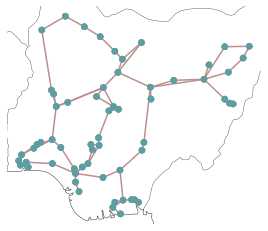

In [23]:
n_solve.plot()

The current data are of the same order of magnitude of those declared by public authorities, yet up-to-date data shall be used.

## 4. Energy production shares

In the following, the total energy production shares as output of the total energy dispatch as available by IEA are compared to those calculated by the pypsa-africa procedure.

The following image depicts the energy demand by source as computed in the Stated Policy Scenarios by [IEA](https://www.iea.org/articles/nigeria-energy-outlook), which is used as a reference for comparison purposes

![Nigerian demand - IEA](../../images/Nigeria_data/Nigeria_demand.png)
[Source link](https://www.iea.org/articles/nigeria-energy-outlook)

In [24]:
# filter only generators in Nigeria
nigeria_generators_dispatch = n_solve.generators_t.p.filter(regex="NG *", axis=1).copy()

# rename column to keep only the carrier
nigeria_generators_dispatch.rename(
    columns=dict(
        zip(
            nigeria_generators_dispatch.columns,
            map(
                lambda x: re.sub(r"NG \d+ ", "", x), nigeria_generators_dispatch.columns
            ),
        )
    ),
    inplace=True,
)

# obtain generation by carrier
(
    nigeria_generators_dispatch.groupby(level=0, axis=1).sum().sum()
    * 8760
    / nigeria_generators_dispatch.shape[0]
    / 1000000
).head(5)

Generator
NG0 0 OCGT      1.355876
NG0 0 onwind    0.000000
NG0 0 solar     0.000000
NG0 1 onwind    0.000069
NG0 1 solar     0.003403
dtype: float64

In [25]:
# create a dataframe with total generation per carrier

# create empty DataFrame with specific column names & types
df = pd.DataFrame(
    {
        "carrier": pd.Series(dtype="str"),
        "pypsa_total_generation [TWh]": pd.Series(dtype="float"),
    }
)

carrier_list = n_solve.generators.carrier.unique()

for i in range(0, len(carrier_list)):
    df.loc[i] = [
        carrier_list[i],
        round(
            n_solve.generators_t.p.filter(like=carrier_list[i], axis=1).sum().sum()
            / 1000000,
            2,
        ),
    ]  # MWh to TWh

df.loc[i + 1] = [
    "hydro",
    round(
        n_solve.storage_units_t.p.filter(like="hydro", axis=1).sum().sum() / 1000000, 2
    ),
]  # MWh to TWh

df.head(10)

,carrier,pypsa_total_generation [TWh]
0,OCGT,6.88
1,onwind,0.00
2,solar,0.04
3,CCGT,16.73
4,oil,0.00
5,hydro,5.84


In [26]:
# import validation data form OurWorldInData
from scripts._helpers import three_2_two_digits_country  # _helpers are from pypsa

url = "https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv"
df = pd.read_csv(url)
df = df.loc[
    :,
    [
        "iso_code",
        "country",
        "year",
        "coal_electricity",
        "gas_electricity",
        "nuclear_electricity",
        "hydro_electricity",
        "solar_electricity",
        "wind_electricity",
    ],
]
df = df[df["iso_code"].notna()]  # removes antartica
df["iso_code_2"] = df.loc[:, "iso_code"].apply(lambda x: three_2_two_digits_country(x))

In [27]:
year_owid = 2020  # option
iso_country_code = "NG"
df = df[df["iso_code_2"] == iso_country_code]
df = df[df["year"] == year_owid]
df.head(2)  # in [TWh]

,iso_code,country,year,coal_electricity,gas_electricity,nuclear_electricity,hydro_electricity,solar_electricity,wind_electricity,iso_code_2
13490,NGA,Nigeria,2020,0.56,21.39,0.0,6.1,0.04,0.0,NG


#### Comments
- Currently Oil (back-up generators) is not dispatched and numbers do not match
- hydro is basically missing